In [12]:
# data prepare
import glob,re,os,sys
os.chdir('C:/kongjy_special/实习工作内容总结/201805-201808华泰证券/Task4/')
sys.path.append('C:\\kongjy_special\\实习工作内容总结\\201805-201808华泰证券\\Task4')
from matplotlib import pyplot as plt
import pandas as pd
import time
import TranFeature,Tools_kjy
import warnings

warnings.filterwarnings('ignore')
pd.options.display.width = 200

# 文件名
TickNameList = glob.glob('Java_log_orders_600519/Tick*.csv')
TranNameList = glob.glob('Java_log_orders_600519/Tran*.csv')
# TestName是 开平仓点 的csv，需要和Tick以及Tran保持时间对齐
DateList = [re.search('\d{8}',i)[0] for i in TickNameList if re.search('\d{8}',i)]  
TestNameFun = lambda x: "Java_log_orders_600519\\600519.SH_back_test_info_" + x +".csv"
TestNameList = [TestNameFun(i) for i in DateList]
print (TickNameList[0])
print (TranNameList[0])
print (TestNameList[0])


Java_log_orders_600519\Tick20180502.csv
Java_log_orders_600519\Tran20180502.csv
Java_log_orders_600519\600519.SH_back_test_info_20180502.csv


In [23]:
# 数据读入 和 预处理
date_index = 5
date = re.search('\d{8}',TickNameList[date_index])[0]
tempTick = pd.read_csv(TickNameList[date_index])
tempTran = pd.read_csv(TranNameList[date_index])
tempTest = pd.read_csv(TestNameList[date_index])
print (TickNameList[date_index])
print (TranNameList[date_index])
print (TestNameList[date_index])
# Tick数据处理
tempTick = tempTick.rename(columns={"Unnamed: 0":"Timestamp"})
tempTick['Timestamp'] = pd.to_datetime(tempTick['Timestamp'])
tempTick['median_5'] = (tempTick['AskP0'].rolling(window=5).median()).shift(-2).fillna(method='pad')
tempTick['median_5'],_ = Tools_kjy.smooth(tempTick['median_5'])
# 开平仓点提取
tickindex = tempTest[tempTest.order != " "].index
print ("Date : %s"%(date))
# # Tran 数据处理
tempTran = tempTran.rename(columns={"Unnamed: 0":"Timestamp"})
tempTran['Timestamp'] = pd.to_datetime(tempTran['Timestamp'])
FeatureTran = TranFeature.TranFeature(tempTran,tempTick)
tempTick = FeatureTran._Tran_features()

print (tempTick.iloc[:20,-11:])

Java_log_orders_600519\Tick20180509.csv
Java_log_orders_600519\Tran20180509.csv
Java_log_orders_600519\600519.SH_back_test_info_20180509.csv
Date : 20180509
_drop_Contunous costs 0.071 seconds!
    Volume  MatchItem  median_5  LowPrice  HighPrice  MedianPrice  CountPrice  MedianBid  MedianAsk  CountBid  CountAsk
0   1900.0        212       NaN    710.51     712.00      711.000        11.0    711.510    710.555       9.0       2.0
1    400.0        216       NaN    711.00     712.28      711.705         4.0    712.280    711.510       1.0       3.0
2    500.0        221    711.53    711.53     711.90      711.900         5.0    711.530    711.900       2.0       3.0
3    300.0        224    711.45    711.01     711.01      711.010         3.0    711.010    711.010       0.0       3.0
4    300.0        227    711.45    711.02     711.45      711.450         3.0    711.450    711.020       2.0       1.0
5   1900.0        238    711.53    711.01     711.90      711.500        11.0    711.5

In [4]:
# 分数判断函数 -- 全局 + 下单位点
# 输出全局的正确率 和 下单点的正确率
def OutScore(x, y):
    '''    x : 测试的单因子，    y : 待预测的量     '''
    Trueindex  = tempTick[tempTick.loc[:,x] == tempTick.loc[:,y]].index
    Trueindex_Order = Trueindex & tickindex
    TotalScore = Trueindex.shape[0] / tempTick.shape[0]
    OrderScore = Trueindex_Order.shape[0] / tickindex.shape[0]
    print("单因子%s，全局正确率:%.3f，下单点正确率:%.3f。"%(x,TotalScore,OrderScore))

def normal(periods):
    argName = 'PastTrend' + str(periods)
    tempTick[argName]  = tempTick['diff1'].rolling(window=periods,min_periods=1).sum().apply(Tools_kjy.trinary)
    OutScore(argName,'isadd_3Tick')

def weighted(periods):
    time_weights = [date_i * date_i for date_i in range(1,periods+1)]
    tempTick['PastTrend'+str(periods)+'_weight'] = tempTick['diff1'].rolling(window=periods).\
                                apply(lambda x:pd.np.multiply(x,time_weights).sum()/sum(time_weights)).apply(Tools_kjy.trinary)
    OutScore('PastTrend'+str(periods)+'_weight','isadd_3Tick')

# 采用过去几个Tick价格的变化 预测 将来3Tick的价格变化
# y -- 3Tick后的价格变化
tempTick['isadd_3Tick'] = tempTick['BidP0'].diff(3).shift(-3).fillna(0).apply(Tools_kjy.trinary)
tempTick['isadd_1Tick'] = tempTick['BidP0'].diff(1).shift(-1).fillna(0).apply(Tools_kjy.trinary)

# x -- 过去价格单因子
tempTick['diff1'] = tempTick['BidP0'].diff().fillna(0)
normal(1);normal(2);normal(3);normal(4);normal(5);normal(6);normal(7);normal(8);normal(9);normal(10);normal(11)
weighted(1);weighted(2);weighted(3);weighted(4);weighted(5);weighted(6);weighted(7);weighted(8);weighted(9);weighted(10);weighted(11)


单因子PastTrend1，全局正确率:0.314，下单点正确率:0.587。
单因子PastTrend2，全局正确率:0.354，下单点正确率:0.760。
单因子PastTrend3，全局正确率:0.370，下单点正确率:0.867。
单因子PastTrend4，全局正确率:0.387，下单点正确率:0.907。
单因子PastTrend5，全局正确率:0.398，下单点正确率:0.827。
单因子PastTrend6，全局正确率:0.410，下单点正确率:0.827。
单因子PastTrend7，全局正确率:0.409，下单点正确率:0.800。
单因子PastTrend8，全局正确率:0.410，下单点正确率:0.773。
单因子PastTrend9，全局正确率:0.413，下单点正确率:0.800。
单因子PastTrend10，全局正确率:0.423，下单点正确率:0.800。
单因子PastTrend11，全局正确率:0.431，下单点正确率:0.787。
单因子PastTrend1_weight，全局正确率:0.314，下单点正确率:0.587。
单因子PastTrend2_weight，全局正确率:0.354，下单点正确率:0.720。
单因子PastTrend3_weight，全局正确率:0.372，下单点正确率:0.813。
单因子PastTrend4_weight，全局正确率:0.383，下单点正确率:0.867。
单因子PastTrend5_weight，全局正确率:0.390，下单点正确率:0.880。
单因子PastTrend6_weight，全局正确率:0.394，下单点正确率:0.893。
单因子PastTrend7_weight，全局正确率:0.396，下单点正确率:0.907。
单因子PastTrend8_weight，全局正确率:0.397，下单点正确率:0.907。
单因子PastTrend9_weight，全局正确率:0.397，下单点正确率:0.893。
单因子PastTrend10_weight，全局正确率:0.397，下单点正确率:0.893。
单因子PastTrend11_weight，全局正确率:0.400，下单点正确率:0.880。


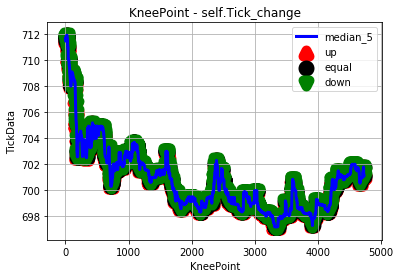

单因子NextDiff，全局正确率:0.328，下单点正确率:0.480。




,NextDiff,KneePoint,isadd_3Tick
0,NaN,0.00,0
1,NaN,0.00,2
2,NaN,0.00,1
3,0.0,0.00,2
4,2.0,0.08,0


In [5]:
# Median5二阶差分研究 , 并研究二阶差分 在图片上的点

tempTick['KneePoint'] = tempTick['median_5'].diff().diff().fillna(0)
    #对下一个点的估计是一阶差分 + 二阶差分
tempTick['NextDiff'] = (tempTick['median_5'].diff() + tempTick['KneePoint']).apply(Tools_kjy.trinary)
Tools_kjy.scatter_classification(tempTick,'KneePoint','median_5')
plt.show()

# 输出得分
OutScore('NextDiff','isadd_3Tick')
print ("\n")
tempTick[['NextDiff','KneePoint','isadd_3Tick']].head(5)


# 结论： 二阶差分现在暂时做不出结论

In [6]:
# 对Trans的数据进行特征提取
# 在tempTran已经提取了一系列特征，包括如下：
# 1. 1Tick内的买卖方市场的中位数价格MedianAsk & MedianBid
# 2. 1Tick内的买卖方市场的交易手数目CountBid  & CountAsk
# 3. 1Tick内的买卖方市场 按Volume计算的25%和75%价格
# 4. 需要计算多个rolling Tick内以上

# 下面提取的特征是针对时间序列的
# 盘口等量
tempTran.head()
Tools_kjy.cumsum(tempTick)
Tools_kjy.findequal(tempTick,5)
Tools_kjy.findequal(tempTick,10)
Tools_kjy.findequal(tempTick,15)
Tools_kjy.findequal(tempTick,20)
Tools_kjy.findequal(tempTick,25)
print ('等体量价格因子done')
Tools_kjy.BidAskPower(tempTick,"Bid")
Tools_kjy.BidAskPower(tempTick,"Ask")
tempTick['TRAN_P1'] = (-tempTick['BidStrength'] + tempTick['AskStrength']).apply(Tools_kjy.trinary)
# 盘口 买方 卖方强度因子 
Tools_kjy.BidAskPower2(tempTick,"Bid")
Tools_kjy.BidAskPower2(tempTick,"Ask")
tempTick['TRAN_P2'] = (-tempTick['BidStrength2'] + tempTick['AskStrength2']).apply(Tools_kjy.trinary)
# 时间尺度上 等量 买方 卖方强度因子 
periods = 6
Tools_kjy.BidAskTime(tempTick,"Bid",periods)
Tools_kjy.BidAskTime(tempTick,"Ask",periods)
tempTick['TRAN_P3'] = (-tempTick['BidStrength'+str(periods)]  + tempTick['AskStrength'+str(periods)]).apply(Tools_kjy.trinary)
# 时间尺度上 盘口 买方 卖方强度因子 
periods = 6
Tools_kjy.BidAskTime2(tempTick,"Bid",periods)
Tools_kjy.BidAskTime2(tempTick,"Ask",periods)
tempTick['TRAN_P4'] = (-tempTick['BidStrength2'+str(periods)] + tempTick['AskStrength2'+str(periods)]).apply(Tools_kjy.trinary)
print ('All done!')


等体量价格因子done
All done!


In [12]:
OutScore('TRAN_P1','isadd_3Tick')
OutScore('TRAN_P2','isadd_3Tick')
OutScore('TRAN_P3','isadd_3Tick')
OutScore('TRAN_P4','isadd_3Tick')

单因子TRAN_P1，全局正确率:0.343，下单点正确率:0.733。
单因子TRAN_P2，全局正确率:0.299，下单点正确率:0.547。
单因子TRAN_P3，全局正确率:0.310，下单点正确率:0.533。
单因子TRAN_P4，全局正确率:0.310，下单点正确率:0.533。


In [7]:
(tempTick.isadd_3Tick == tempTick.TRAN_P2).sum()

1275